In [22]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [127]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [128]:
BASE_FOLDER = '/content/drive/My Drive/Universidad/TFM/MVP/'

In [129]:
X = pd.read_csv(BASE_FOLDER + 'train.csv', index_col=0).values
scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
X = scaler.transform(X)
X

array([[0.02994908, 0.33963772, 0.74670282, 0.40797641],
       [0.02285934, 0.38337146, 0.53883942, 0.51339138],
       [0.021974  , 0.41500796, 0.65546647, 0.48162216],
       ...,
       [0.91499597, 0.40825847, 0.56507406, 0.6333923 ],
       [0.92685261, 0.1807568 , 0.99500155, 0.571861  ],
       [0.9261304 , 0.11454294, 0.6041293 , 0.47926122]])

In [130]:
Y = pd.read_csv(BASE_FOLDER + 'target.csv', index_col=0)
# Only use the close for the moment
y = Y[['close']].values
scaler = MinMaxScaler(feature_range=(0,1)).fit(y)
y = scaler.transform(y)

In [131]:
assert len(X) == len(y)

### Split train-test (Test with 90%)

In [132]:
split = int(len(X) * 0.9)
split

328

In [133]:
X_train = X[:split]
X_test = X[split:len(X)]
y_train = y[:split]
y_test = y[split:len(y)]

In [134]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

### Shift and build input
We will have n (look_back) and we will shift our target accordingly

In [149]:
n = 3 # number of observations

Xtrain = []
ytrain = []
Xtest = []
ytest = []

for i in range(n ,len(X_train)):
  Xtrain.append(X_train[i-n : i, : X_train.shape[1]])
  ytrain.append(y_train[i]) # predict the next record

for i in range(n, len(X_test)):
  Xtest.append(X_test[i-n : i, : X_test.shape[1]])
  ytest.append(y_test[i])

In [150]:
# We have 3 timestamps
Xtrain[0]

array([[0.02994908, 0.33963772, 0.74670282, 0.40797641],
       [0.02285934, 0.38337146, 0.53883942, 0.51339138],
       [0.021974  , 0.41500796, 0.65546647, 0.48162216]])

In [151]:
# and one target for the 3 dates
ytrain[0]

array([0.00353634])

In [152]:
# let's convert our data to numpy arrays
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))

Xtest, ytest = (np.array(Xtest), np.array(ytest))

In [153]:
# We will include our timestamp
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [154]:
print(Xtrain.shape)
print(ytrain.shape)
print()
print(Xtest.shape)
print(ytest.shape)

(325, 3, 4)
(325, 1)

(34, 3, 4)
(34, 1)


### Build LSTM and train

- Number of observations
- timesteps
- features

In [155]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [156]:
regressor = Sequential()

regressor.add(LSTM(units = 50, input_shape = (Xtrain.shape[1], Xtrain.shape[2]), return_sequences = True))
regressor.add(Dense(1, activation='linear'))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(Xtrain, ytrain, epochs = 100, batch_size = 32, validation_data = (Xtest, ytest))

Epoch 1/100
11/11 [==============================] - 2s 54ms/step - loss: 0.0383 - val_loss: 0.2694
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0282 - val_loss: 0.2347
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0238 - val_loss: 0.2325
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.2100
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.1753
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0120 - val_loss: 0.1494
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0095 - val_loss: 0.1216
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0076 - val_loss: 0.1066
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0952
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0918
Epoch 1

In [157]:
regressor.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 3, 50)             11000     
_________________________________________________________________
dense_10 (Dense)             (None, 3, 1)              51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


### Eval the prediction

In [158]:
train_predict = regressor.predict(Xtrain)


In [191]:
y_test_real = scaler.inverse_transform(ytest)
y_test_predicted = scaler.inverse_transform(test_predict)

y_test_real = [y_test_real[idx][0] for idx in range(0, len(y_test_real))]
y_test_predicted = np.array([y_test_predicted[idx][0] for idx in range(0, len(y_test_predicted))])

df = pd.DataFrame()
df['real'] = y_test_real
df['predicted'] = y_test_predicted

# Our real data is shifted 3 days because we get the results for n days in the future

df['predicted'] = df['predicted'].shift(n * -1)
df = df[:-3]

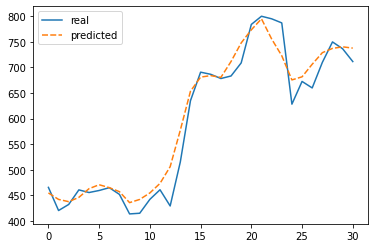

In [192]:
sns.lineplot(data=df)

In [193]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df['real'], df['predicted'], squared=False)
print(f"MSE: {mse}")

MSE: 29.289366829604596


In [204]:
tend = pd.DataFrame()

# Let's get the accuracy of the market tendencies
tend['real'] = df['real'].diff().clip(-1,1)
tend['predicted'] = df['predicted'].diff().clip(-1,1)

# Let's remove first row as is nan
tend = tend[1:len(tend)]

sns.lineplot(data=tend)

In [205]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(tend['real'], tend['predicted'])
print(f"Accuracy for market daily direction: {acc}")


Accuracy for market daily direction: 0.7666666666666667
